
## Random Forest Regressor to Predict Concrete Comprehensive Strength

The purpose of this notebook is to create a model to try and predict the the compressive strength of concrete based on the dataset provided while trying to maintain as small of a mean squared error as possible. 

Concrete is one of the most used materials in construction and. For designers, compressive strength is one of the most important engineering properties of concrete.

In this particular dataset the compressive strength is measured in Mpa (Mega-Pascals). All the features except the age are measured in kilograms per cubic metre (kg/m^3). As for the age, it is measured in days.

Original paper: I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).

Kaggle data: https://www.kaggle.com/maajdl/yeh-concret-data/data

*Note: If you choose to re-run this notebook, the values observed may not come out as presented.

In [1]:
import pandas
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import math

In [2]:
df = pandas.read_csv('Concrete_Data_Yeh.csv')

In [3]:
x = df.drop('csMPa', axis=1)

y = pandas.DataFrame(df['csMPa'])
y.columns = ['concrete_compressive_str_MPa']

In [4]:
# Divide the the dataset into 3: training data (60%), cross-validation data (20%) and testing data (10%)
# First split data into training and test data
proportion_of_training = 0.9
train_test_cutoff = int(x.shape[0] * proportion_of_training) 
x_train = x.iloc[0:train_test_cutoff]
y_train = y.iloc[0:train_test_cutoff]

# test
x_test = x.iloc[train_test_cutoff+1:]
y_test = y.iloc[train_test_cutoff+1:]

# Now split X_train further into actual training and cross-validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.23)

x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [5]:
# Implementing Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000, max_depth=None)

rfr.fit(x_train, y_train.values.ravel()) # used ravel() to get rid of a warning message

mse = mean_squared_error(y_val, rfr.predict(x_val))
print('{} had an MSE of {}'.format('Random forest regressor', mse))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse)))

Random forest regressor had an MSE of 21.27373947457177
	 this means the average guess is off by 4.612346417450858 mega Pascals


In [6]:
# This is to print the coefficents of importance of the features based on the Random Forest Regressor
for i in range(8):
    print('{} = {}'.format(x_train.columns.values[i], rfr.feature_importances_[i]))

cement = 0.2681467504899606
slag = 0.04706883894702727
flyash = 0.024257875027096927
water = 0.15012109648760116
superplasticizer = 0.05478633179611407
coarseaggregate = 0.02702742045526726
fineaggregate = 0.06252873621732004
age = 0.36606295057961274


With the magnitudes observed above, the importance of the features is as follows:  age > cement > water > fineaggregate > superplasticizer > slag > coarseaggregate > flyash

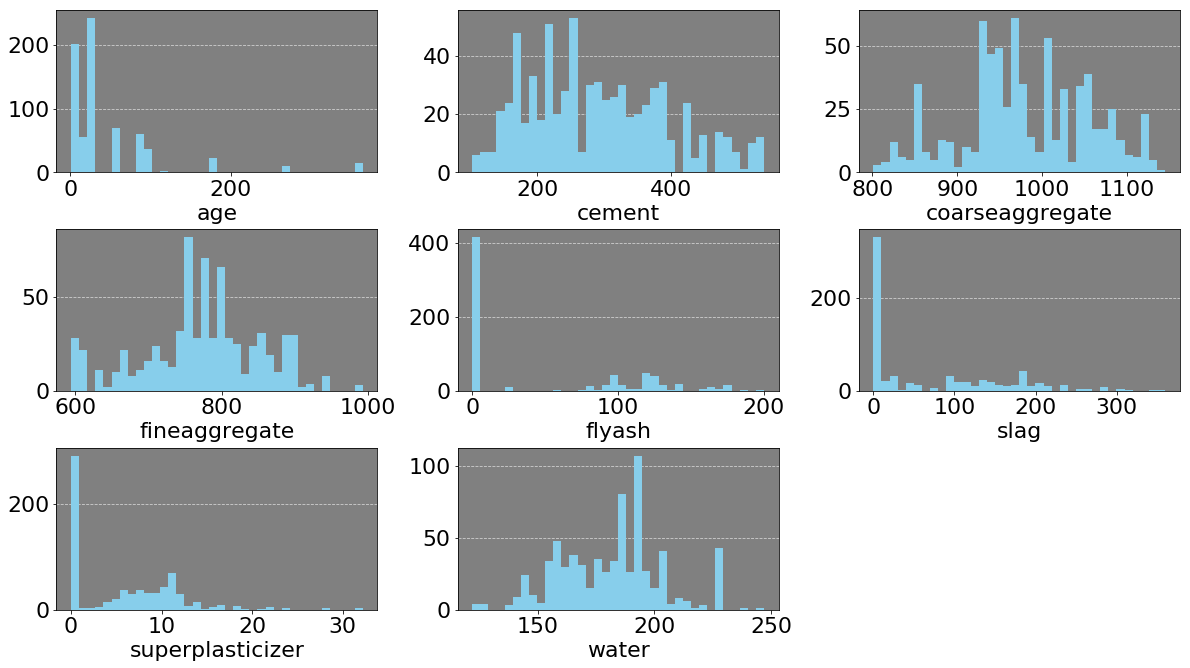

In [8]:
# The distributions of each of those variables

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 22


num_cols = round(math.sqrt(x_train.shape[1]))
num_rows = round(math.sqrt(x_train.shape[1])) + 2
sorted_cols = sorted(x_train.columns)


fig = plt.figure(1, figsize=(26, 24))
num_plotted_subplots = 0
for col in sorted_cols:
    num_plotted_subplots += 1
    ax = fig.add_subplot(num_rows, num_cols, num_plotted_subplots)
    
    ax.hist(x_train[col].values, color='skyblue', bins=36)
    
    ax.grid(color='lightgray', linestyle='--', axis='y')
    ax.set_axisbelow(True)
    ax.set_facecolor(color='gray')
    ax.set_xlabel(col)
plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.8,
        wspace=0.25, hspace=0.35)
plt.show()

By observing the distributions and the feature importance coefficients; the age feature has a low variability and a high importance. Therefore, it is a possible culprit for the higher mean squared error. Further investigation is required. This can be done by plotting a residual plot for the random forest regressor based on the age.

[27.66 34.57 14.99 45.85 41.2  54.9  39.78 46.8  29.22 38.7 ]
[28.92908    33.91740367 14.97791    43.05347    41.88064    57.70649467
 39.38271    48.20677495 28.87688    38.49702   ]


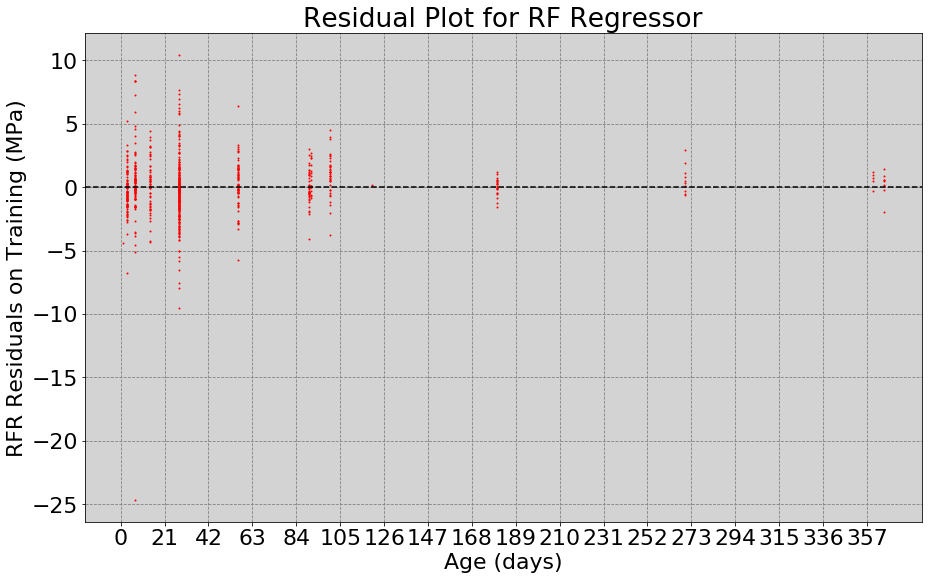

In [9]:
import matplotlib.pyplot as plt
import matplotlib

mlpr_train_predictions = rfr.predict(x_train)
mlpr_train_actuals = y_train.values.ravel()
train_ages = x_train['age'].values.ravel()


fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 9)

# To observe difference between predictions and actual values
print(mlpr_train_actuals[0:10])
print(mlpr_train_predictions[0:10])

ax.scatter(train_ages, mlpr_train_actuals - mlpr_train_predictions, color='red', s=1)
ax.axhline(0, color='black', linestyle='--')

ax.set_xlabel('Age (days)')
ax.set_ylabel('RFR Residuals on Training (MPa)')
ax.set_title('Residual Plot for RF Regressor')
ax.set_xticks( range(0, int(max(train_ages))+5, 21) )
ax.set

ax.grid(color='gray', linestyle='--', axis='both')
ax.set_axisbelow(True)
ax.set_facecolor(color='lightgray')

plt.show()

In [10]:
# Observe the percentage of data to work with for different cutoffs
cutoffs = [7, 21, 30, 50, 100]
for cutoff in cutoffs:
    print('{0:.1f}% with age > {1}'.format(100.0 * x_train[ x_train.age > cutoff ].shape[0] / x_train.shape[0], cutoff)) 

71.8% with age > 7
64.1% with age > 21
30.2% with age > 30
30.2% with age > 50
6.7% with age > 100


In [11]:
# Try the 30 day cutoff and train 2 Random Forest Regressors, and see their MSE
cutoff = 30 # ≤ this and > this

# split the data on the specified cutoff
# do all of the > cutoff stuff first
x_train_age_gt = x_train[ x_train['age'] > cutoff] # gt means "greater than"
y_train_age_gt = y_train.iloc[[i for i in x_train_age_gt.index]]

# Train
rfr_1 = RandomForestRegressor(n_estimators=1000, max_depth=None)
rfr_1.fit( x_train_age_gt, y_train_age_gt.values.ravel())

# > 30 MSE training
mse_gt = mean_squared_error(y_train_age_gt, rfr_1.predict(x_train_age_gt) )                 
print('Random Forest Regressor for age greater than {} days had a training MSE of {}'.format(cutoff, mse_gt))

# > 30 validation 
x_val_age_gt = x_val[ x_val['age'] > cutoff]
y_val_age_gt = y_val.iloc[[i for i in x_val_age_gt.index]]

# > 30 MSE validation
mse_gt = mean_squared_error(y_val_age_gt, rfr_1.predict( x_val_age_gt) )
print('Random Forest Regressor for age greater than {} days had a validation MSE of {}'.format(cutoff, mse_gt))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse_gt)))

Random Forest Regressor for age greater than 30 days had a training MSE of 3.110951424990339
Random Forest Regressor for age greater than 30 days had a validation MSE of 14.23301135306648
	 this means the average guess is off by 3.77266634531421 mega Pascals


In [12]:
# NOW for the <= cutoff part
# split the data on the cutoff already given
x_train_age_lteq = x_train[ x_train['age'] <= cutoff] # lteq means "less than or equal to"
y_train_age_lteq = y_train.iloc[[i for i in x_train_age_lteq.index]]

# Train
rfr_2 = RandomForestRegressor(n_estimators=1000, max_depth=None)
rfr_2.fit( x_train_age_lteq, y_train_age_lteq.values.ravel())

# <= 30 MSE training
mse_lteq = mean_squared_error(y_train_age_lteq, rfr_2.predict(x_train_age_lteq))
print('Random Forest Regressor for age less than or equal to {} days had a training MSE of {}'.format(cutoff, mse_lteq))


# <= cutoff validation
x_val_age_lteq = x_val[ x_val['age'] <= cutoff]
y_val_age_lteq = y_val.iloc[[i for i in x_val_age_lteq.index]]

# <= 30 MSE validation
mse_lteq = mean_squared_error(y_val_age_lteq, rfr_2.predict(x_val_age_lteq))
print('Random Forest Regressor for age greater than {} days had a validation MSE of {}'.format(cutoff, mse_gt))
print('\t this means the average guess is off by {} mega Pascals'.format(math.sqrt(mse_gt)))

Random Forest Regressor for age less than or equal to 30 days had a training MSE of 7.17146216844906
Random Forest Regressor for age greater than 30 days had a validation MSE of 14.23301135306648
	 this means the average guess is off by 3.77266634531421 mega Pascals


In [ ]:
# Prediction function to test the model
def predict():
    cement = float(input("Please enter the cement content (kg/m^3):"))
    slag = float(input("Please enter the blast furnace slag content (kg/m^3):"))
    fly_ash = float(input("Please enter the fly ash content (kg/m^3):"))
    water = float(input("Please enter the water content (kg/m^3):"))
    splasticizer = float(input("Please enter the superplasticizer content (kg/m^3):"))
    cagg = float(input("Please enter the course aggregate content (kg/m^3):"))
    fagg = float(input("Please enter the fine aggregate content (kg/m^3):"))
    age = float(input("Please enter the age (days):"))
    Y = np.array([[cement, slag, fly_ash, water, splasticizer, cagg, fagg, age]])
    if age > 30:
        return rfr_1.predict(Y)
    else:
        return rfr_2.predict(Y)
print(' Compressive strength = {} Mpa'.format(predict())

The model above was, ofcourse, not achieved in one try. After multiple trial and error, the Random Forest Regressor proved to be better than the other machine learning models.

The function at the end of the notebook is for running the model; feel free and have fun.

Thank you for taking your time to look at my work...

E-mail: telebwe@gmail.com

Wechat: @zavi_203